In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
path = os.getcwd()

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 716491562590048531
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4486001150218281980
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


* 데이터셋

In [3]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


* 모델 학습

In [28]:
# class CBR2d(tf.keras.layers.Layer):
#     def __init__(self, out_channels,kernel_size = 3):
#         super(CBR2d, self).__init__()
#         self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
#         self.batch_layer = tf.keras.layers.BatchNormalization()
              
#     def call(self, inputs):
#         cnn_feat_x = self.cnn_layer(inputs)
#         batched_feat = self.batch_layer(cnn_feat_x)
#         return batched_feat

class Weakdnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakdnn, self).__init__()
        self.layer_1 = tf.keras.layers.Dense(128, activation='relu')
        self.batch_layer_1 = tf.keras.layers.BatchNormalization()
        self.layer_2 = tf.keras.layers.Dense(256, activation='relu')
        self.batch_layer_2 = tf.keras.layers.BatchNormalization()
        self.layer_3 = tf.keras.layers.Dense(512, activation='relu')
        self.batch_layer_3 = tf.keras.layers.BatchNormalization()
        self.layer_4 = tf.keras.layers.Dense(256, activation='relu')
        self.batch_layer_4 = tf.keras.layers.BatchNormalization()
        self.layer_5 = tf.keras.layers.Dense(128, activation='relu')
        self.batch_layer_5 = tf.keras.layers.BatchNormalization()
        

        self.out_layer = tf.keras.layers.Dense(64*64)

    def call(self, input): 

        x = self.layer_1(input)
        x = self.batch_layer_1(x)
        x = self.layer_2(x)
        x = self.batch_layer_2(x)
        x = self.layer_3(x)
        x = self.batch_layer_3(x)
        x = self.layer_4(x)
        x = self.batch_layer_4(x)
        x = self.layer_5(x)
        x = self.batch_layer_5(x)

        x = self.out_layer(x)
        return x

In [100]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        if pre_weak_net is None: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_val).numpy() 
            self.y_val = y_val
        else:
            self.y_val = y_val - pre_weak_net(x_val).numpy() 


        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        # self.input_shape = input_shape # [70,64,64,3]
        self.input_shape = [70,64,64,4]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None
        # dnn처리용으로 잠시 input사이즈 고정 cnn인풋에서는 할 필요없음
        ax1 = np.random.randint(self.input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(self.input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(self.input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val.reshape([len(self.x_val),64,64,4])[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val.reshape([len(self.x_val),64,64,4])[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr.reshape([len(x_arr),64,64,4])[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        # pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        pred_val = np.zeros(shape=(input_shape[0],self.y_val.shape[1]))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
       
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [101]:
class bagging_dnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakdnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,4]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
       
        
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]
            
            
            i_tree = Restree(pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [149]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_train_tensor = tf.reshape(x_train_tensor,[x_train_tensor.shape[0], -1])
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_train_resize_tensor = tf.reshape(y_train,[y_train.shape[0], -1])
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 3
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakdnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/3--- mse-loss: 177.2259979248047
batch: 2/7.0 ---epoch: 0/3--- mse-loss: 180.4093017578125
batch: 3/7.0 ---epoch: 0/3--- mse-loss: 174.24746704101562
batch: 4/7.0 ---epoch: 0/3--- mse-loss: 170.14163208007812
batch: 5/7.0 ---epoch: 0/3--- mse-loss: 162.0706787109375
batch: 6/7.0 ---epoch: 0/3--- mse-loss: 146.42349243164062
batch: 7/7.0 ---epoch: 0/3--- mse-loss: 123.4178695678711
batch: 1/7.0 ---epoch: 1/3--- mse-loss: 89.14073181152344
batch: 2/7.0 ---epoch: 1/3--- mse-loss: 52.79418182373047
batch: 3/7.0 ---epoch: 1/3--- mse-loss: 40.458946228027344
batch: 4/7.0 ---epoch: 1/3--- mse-loss: 61.568267822265625
batch: 5/7.0 ---epoch: 1/3--- mse-loss: 42.932411193847656
batch: 6/7.0 ---epoch: 1/3--- mse-loss: 18.081396102905273
batch: 7/7.0 ---epoch: 1/3--- mse-loss: 9.730720520019531
batch: 1/7.0 ---epoch: 2/3--- mse-loss: 12.498507499694824
batch: 2/7.0 ---epoch: 2/3--- mse-loss: 15.671003341674805
batch: 3/7.0 ---epoch: 2/3--- mse-loss: 15.305723190307617
batc

In [150]:
bagging = bagging_dnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= 5,
    y_val= y_train.reshape([y_train.shape[0],-1]),
    x_val= x_train.reshape([x_train.shape[0],-1]),
    is_terminal= False,

    kernel_size= [5,5],
    kernel_n= 10,

    input_shape= x_train.reshape([x_train.shape[0],-1]).shape,

    n_tree= 20,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


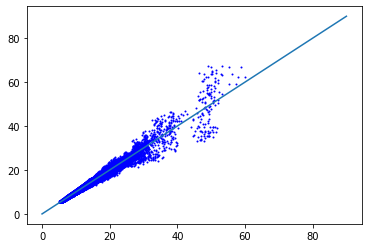

In [151]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train.reshape([x_train.shape[0],-1]))
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

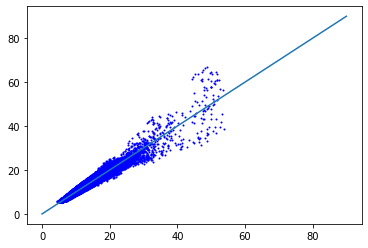

In [152]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test.reshape([x_test.shape[0],-1]))
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

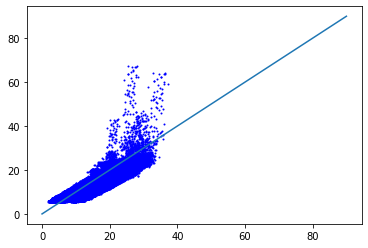

In [153]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train.reshape([x_train.shape[0],-1])).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape([y_train.shape[0],-1]).reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

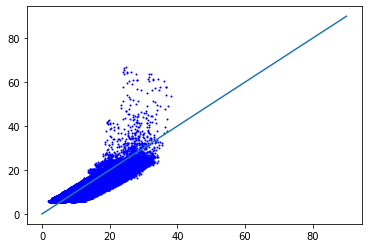

In [154]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test.reshape([x_test.shape[0],-1])).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape([pm2_5.shape[0],-1]).reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

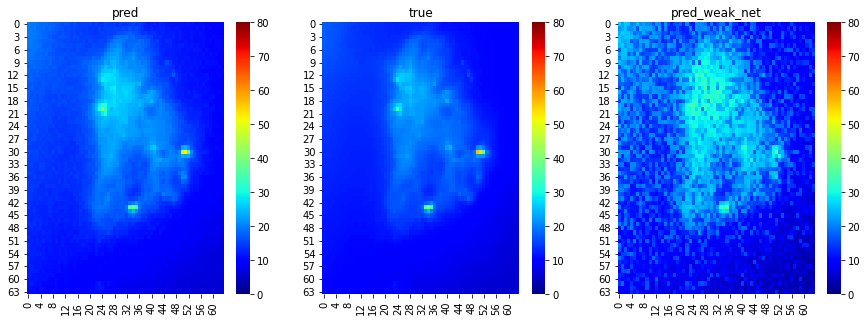

In [155]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

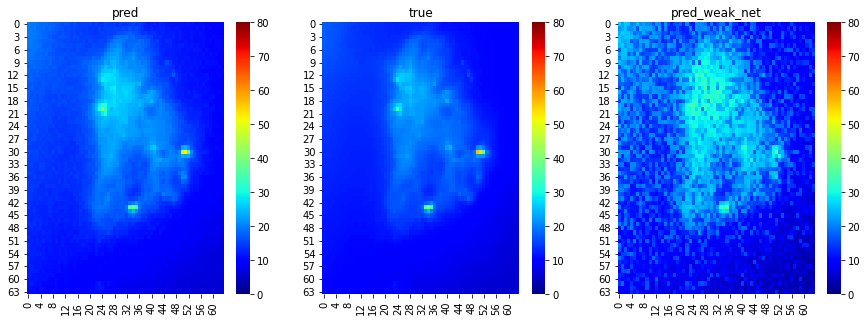

In [156]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

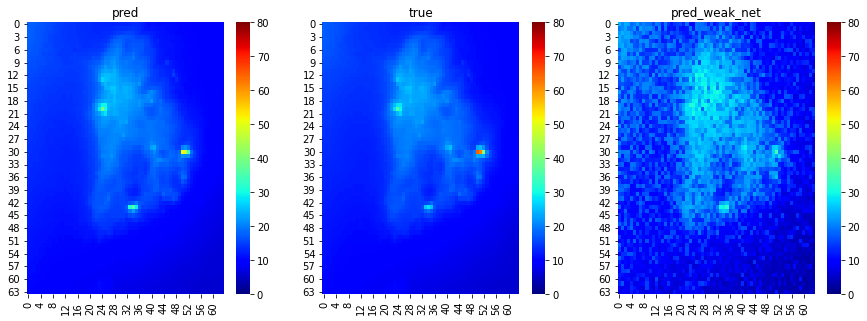

In [157]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

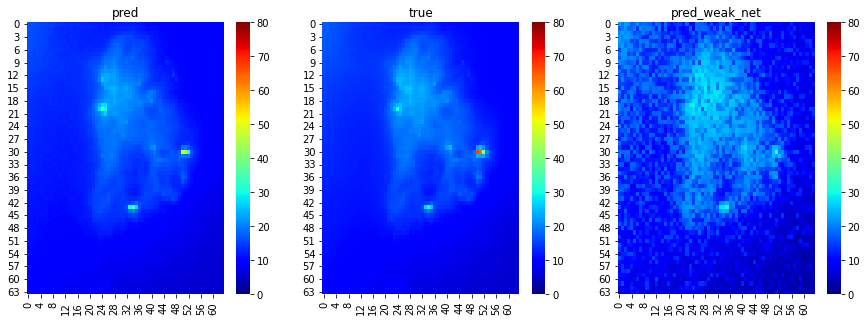

In [158]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i].reshape([64,64,1])[:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

* contribution analysis